**Table of contents**<a id='toc0_'></a>    
- [Elimination event segmentation](#toc1_1_)    
    - [Setup](#toc1_1_1_)    
    - [Dataset](#toc1_1_2_)    
  - [Training and eval](#toc1_2_)    
  - [Conclusions](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Elimination event segmentation](#toc0_)

Trying out Meta's Segment Anything Model (SAM) to try to segment out elimination events from video frames.

With this in place, we can start with some simple rules to classify videos and possibly trim clips.

### <a id='toc1_1_1_'></a>[Setup](#toc0_)

In [1]:
%matplotlib inline

import os
import pathlib
import random

from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
device = "cuda"

DATA_DIR = pathlib.Path('/data/autotrim/datasets/')
FRAMES_DATA_DIR = DATA_DIR / 'frames'
COCO_DATASET_DIR = DATA_DIR / 'frames-annotated-coco'

In [3]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)



def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def bbox_to_mask(bbox: List, img_h: int, img_w: int):
    left_x, top_y, bbox_w, bbox_h = bbox
    right_x = left_x + bbox_w
    bottom_y = top_y + bbox_h

    mask = np.zeros((img_h, img_w))

    mask[int(top_y):int(bottom_y),  int(left_x):int(right_x)] = 1

    return mask

def box_to_mask(box: List, img_h: int, img_w: int):
    left_x, top_y, right_x, bottom_y = box

    mask = np.zeros((img_h, img_w))

    mask[int(top_y):int(bottom_y),  int(left_x):int(right_x)] = 1

    return mask

### <a id='toc1_1_2_'></a>[Dataset](#toc0_)

Load a dataset in COCO format and evaluate SAM's performance compared to labelled samples.

In [4]:
import enum
from io import BytesIO
from urllib.parse import urlparse

from typing import Any, Tuple

from PIL import Image
import boto3
import torch
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO

from csgo_clips_autotrim.experiment_utils.secrets import Secrets

In [5]:
ANNOTATIONS_PATH = COCO_DATASET_DIR / 'result.json'
secrets = Secrets.load()

s3 = boto3.resource('s3', 
  endpoint_url='https://minio-api.tenzing.shkhr.ovh',
  aws_access_key_id=secrets.MINIO_AWS_ACCESS_KEY_ID,
  aws_secret_access_key=secrets.MINIO_AWS_SECRET_ACCESS_KEY,
  aws_session_token=None,
  config=boto3.session.Config(signature_version='s3v4')
)
s3_client = s3.meta.client

In [6]:
def load_image_from_s3(uri: str) -> Image.Image:
    clean_uri = uri.replace('\\', '')
    parsed_uri = urlparse(clean_uri)
    bucket_name, path = parsed_uri.hostname, parsed_uri.path[1:]

    response = s3_client.get_object(Bucket=bucket_name, Key=path)
    img_data = response['Body'].read()
    img = Image.open(BytesIO(img_data))

    return img

In [7]:
class EliminationEventsDataset(torch.utils.data.Dataset):
    """ Torch dataset of the annotated elimination events.
    """
    class Categories(enum.Enum):
        ELIMINATED = 0
        ELIMINATION_EVENT = 1
        ELIMINATOR = 2
        WEAPON = 3
        
    def __init__(self, annotation_file_path: str, transforms=None, event_types = [Categories.ELIMINATION_EVENT]):
        self.transforms = transforms
        self.coco = COCO(annotation_file_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.event_types = event_types

    def _load_image(self, id: int) -> Image.Image:
        img_uri = self.coco.loadImgs(id)[0]['file_name']
        return load_image_from_s3(img_uri)
    
    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # Load the input image
        img = self._load_image(img_id)

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Only focus on elim
        categories = [EliminationEventsDataset.Categories(ann['category_id']) for ann in coco_annotation]
        elimination_event_ids = [i for i in range(num_objs) if categories[i] in self.event_types]

        num_objs = len(elimination_event_ids)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in elimination_event_ids:
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        if not elimination_event_ids:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []

        for i in elimination_event_ids:
            areas.append(coco_annotation[i]['area'])

        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [8]:
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


5


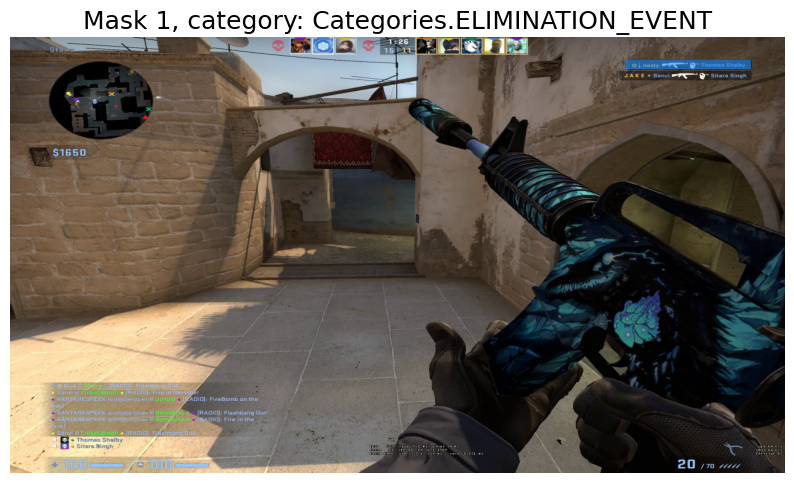

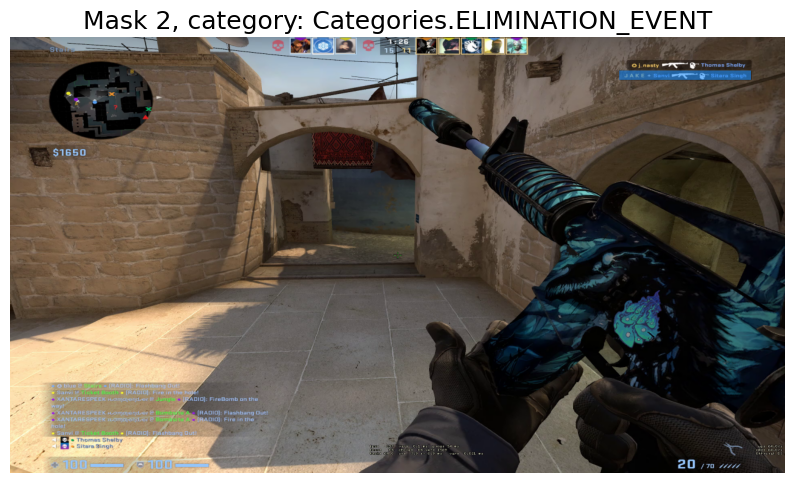

In [9]:
sample = random.choice(dataset)
img, anns = sample

print(len(anns))

for i in range(len(anns['boxes'])):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    mask = box_to_mask(anns['boxes'][i], img.height, img.width)
    show_mask(mask, plt.gca())
    category = EliminationEventsDataset.Categories(anns['labels'][i].numpy())
    plt.title(f"Mask {i+1}, category: {category}", fontsize=18)
    plt.axis('off')
    plt.show()  

### <a id='toc1_2_'></a>[Training and eval](#toc0_)

In [10]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

torch.manual_seed(42)

train_size = int(TRAIN_RATIO  * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - (train_size + val_size)

dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH, transforms=torchvision.transforms.ToTensor())

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [11]:
# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [13]:
# Load a pre-trained Mask R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

/home/shikhar/.pyenv/versions/csgo-clips-autotrim-py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shikhar/.pyenv/versions/csgo-clips-autotrim-py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Modify the last fully connected layer for the number of classes in your dataset
num_classes = 2
# num_classes = len(EliminationEventsDataset.Categories)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# Set device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
# Define optimizer and loss function.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for images, targets in train_data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_data_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 2.1126
Epoch [2/10], Loss: 2.0720
Epoch [3/10], Loss: 2.1154
Epoch [4/10], Loss: 2.0397
Epoch [5/10], Loss: 2.2369
Epoch [6/10], Loss: 2.0669
Epoch [7/10], Loss: 2.1034
Epoch [8/10], Loss: 2.0351
Epoch [9/10], Loss: 2.0280
Epoch [10/10], Loss: 2.0373


In [36]:
from csgo_clips_autotrim.experiment_utils.references import engine

engine.evaluate(model, val_data_loader, device=device)

creating index...
index created!
Test:  [0/4]  eta: 0:00:06  model_time: 0.5436 (0.5436)  evaluator_time: 0.0026 (0.0026)  time: 1.6285  data: 1.0741  max mem: 2095
Test:  [3/4]  eta: 0:00:00  model_time: 0.3308 (0.3328)  evaluator_time: 0.0019 (0.0019)  time: 0.6209  data: 0.2794  max mem: 2095
Test: Total time: 0:00:02 (0.6303 s / it)
Averaged stats: model_time: 0.3308 (0.3328)  evaluator_time: 0.0019 (0.0019)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.

In [67]:
img, _ = random.choice(val_dataset)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [68]:
img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

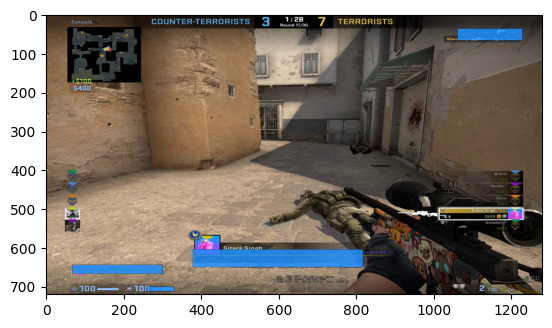

In [69]:
plt.imshow(img)

for box in prediction[0]['boxes']:
    mask = box_to_mask(box, 720, 1280)
    show_mask(mask, plt.gca())
    # plt.figure(figsize=(10,10))
    show_mask(mask, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    # plt.axis('off')

plt.show()  

### <a id='toc1_3_'></a>[Conclusions](#toc0_)


The OOB performance of the model is understandably very poor.
While it is able to find the elimination events in some cases, in most cases, it commits the following types of errors:

1. Selecting a completely different region of the image as the answer: we'll retry by reducing the size of the frame passed in to the image to the top right quadrant, since elimination events are mostly restricted to that region.
2. Not being able to distinguish between individual events: This might be helped by image preprocessing like thresholding, edge detection etc. to provide as crisp decision boundary as possible to the model.